In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import jax
import pytensor

In [7]:
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(seed=2025)

jax.config.update("jax_enable_x64", False)
pytensor.config.floatX = "float32"

In [11]:
import hssm

# Introduction to the HSSM Toolbox

**Behavioral Data Science, Spring 2025**

In this notebook, we introduce the basic usage of the [HSSM](https://lnccbrown.github.io/HSSM/) (Hierarchical Sequential Sampling Modeling) toolbox for studying decision-making processes using a broad class of drift-diffusion models (DDM). 

## Review: Drift-Diffusion Model

As we have learned in class over the past two weeks, drift-diffusion models (DDMs) are a broad class of choice-decision models, with the decision-making process represented as a stochastic differential equations.

The model is governed by four key parameters:

1. Drift rate ($v$): speed of decision-making
2. Decision boundary ($a$): threshold of choice-alternative separation
3. Starting point ($b$): initial conditions of decision-making (or, an *a priori* decision bias)
4. Non-decision time ($\tau$): the time delay for the decision-making process to start

In [8]:
# Create a dictionary that stores the parameters
true_params = {
    "v": 0.5,
    "a": 1.5,
    "z": 0.5,
    "t": 0.5
}

The [`ssms`](https://github.com/lnccbrown/ssm-simulators) (Sequential Sampling Modeling Simulators) package is used under the hood to simulate the data.

In [12]:
dataset = hssm.simulate_data(model="ddm", theta=true_params, size=1000)

In [39]:
type(dataset)

pandas.core.frame.DataFrame

In [40]:
dataset.shape

(1000, 2)

Text(0.5, 0, 'Reaction Time (sec)')

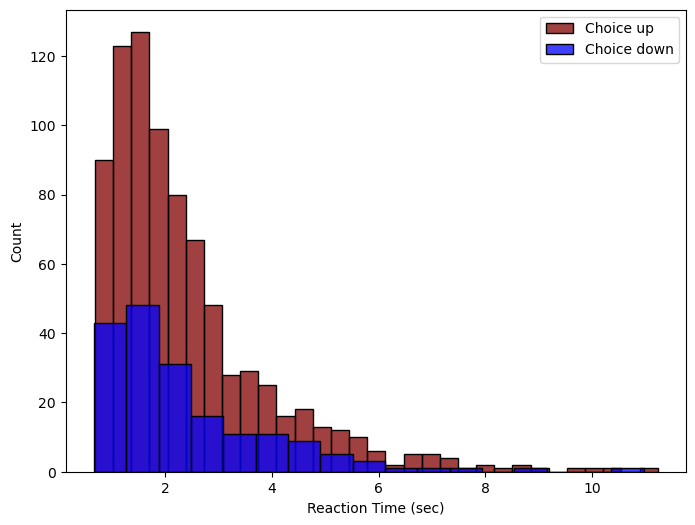

In [24]:
# Plotting the simulated data as a simple histogram
f, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = sns.histplot(dataset.rt[dataset.response == 1], color='maroon')
ax = sns.histplot(dataset.rt[dataset.response == -1], color='blue')

ax.legend(['Choice up', 'Choice down'])
ax.set_xlabel('Reaction Time (sec)')

... you know, the familiar stuff. The simulated data consists of **reaction time** and **choice**.

The `HSSM` class creates a [PyMC](https://www.pymc.io/welcome.html) model, and initialize it when provided the simulated dataset.

In [25]:
simple_ddm = hssm.HSSM(data=dataset)

Model initialized successfully.


Now, let's look at what this model has. Since this is a PyMC model, HSSM allows us to show the model structure both textually and graphically.

In [26]:
simple_ddm

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

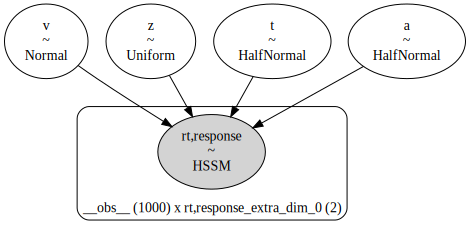

In [27]:
simple_ddm.graph()

A quick note about this diagram: it is called the **plate notation**, used often in probabilistic graphical models. 

* White nodes: **parameters**, these are random variables in the model and we want to estimate them.
* Gray nodes: **observed variables**, are fixed (or conditioned on).
* Rounded rectangles: **the plate**, provide us with information about dimensionality of objects (i.e., number of observations).
* Rectangles with sharp edges: **deterministic, but computed quantities**.

We can show it here because, again, HSSM utilizes a PyMC backbone, which inherits the diagram from GraphViz. For the same reason, we see that HSSM samples from the model in a similar way as PyMC.

In [ ]:
simple_ddm_samples = simple_ddm.sample(
    sampler="mcmc",     # type of sampler to choose
    cores=4,            # how many cores to use
    chains=4,           # how many chains to run
    draws=500,          # number of draws from the markov chain
    tune=500,           # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
    mp_ctx="spawn",
)

Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, a, v]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 178 seconds.
100%|██████████| 2000/2000 [00:03<00:00, 649.73it/s]


The sampled parameters are bundled together as an ArViZ `InferenceData` object. We can inspect it by directly calling the variables. To access parts of the posterior samples, we can also extract them as a `NumPy` array.

In [29]:
simple_ddm_samples

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [30]:
simple_ddm_samples.posterior.v.values

array([[0.53722185, 0.5089991 , 0.5089991 , ..., 0.5987197 , 0.5760287 ,
        0.51177615],
       [0.5477842 , 0.5818695 , 0.59189165, ..., 0.60695726, 0.5828904 ,
        0.5136022 ],
       [0.617985  , 0.58729815, 0.5654565 , ..., 0.56313163, 0.5846035 ,
        0.54348105],
       [0.5465156 , 0.597413  , 0.5420499 , ..., 0.51258683, 0.58156765,
        0.59795773]], dtype=float32)

### Diagnostics

Because of the use of the ArViZ `InferenceObject`, we can do all of our diagnostics out of the box from ArViZ as well.

In [31]:
az.summary(simple_ddm_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.493,0.013,0.469,0.518,0.000,0.000,1315.0,1430.0,1.0
v,0.548,0.034,0.485,0.609,0.001,0.001,1277.0,1407.0,1.0
t,0.493,0.020,0.452,0.528,0.001,0.000,1173.0,1305.0,1.0
a,1.467,0.028,1.407,1.513,0.001,0.001,1243.0,1390.0,1.0


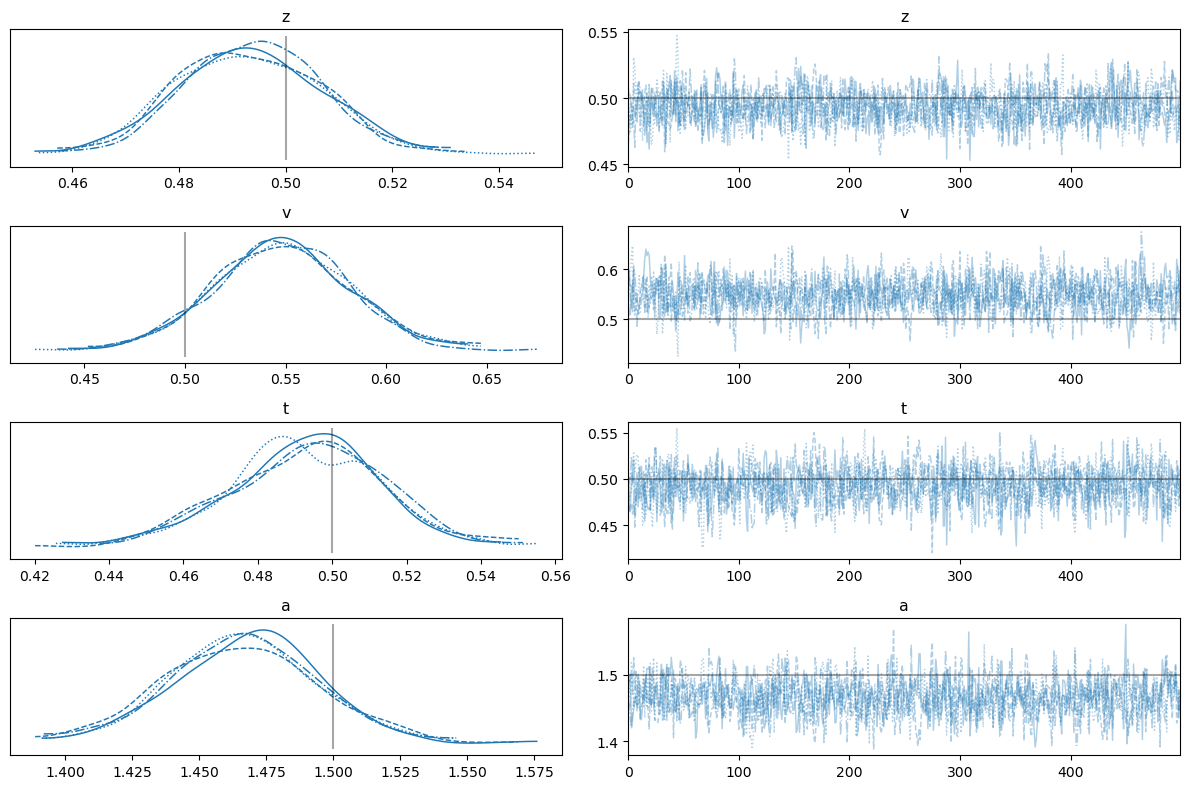

In [32]:
az.plot_trace(simple_ddm_samples, lines=[(key, {}, true_params[key]) for key in true_params],)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

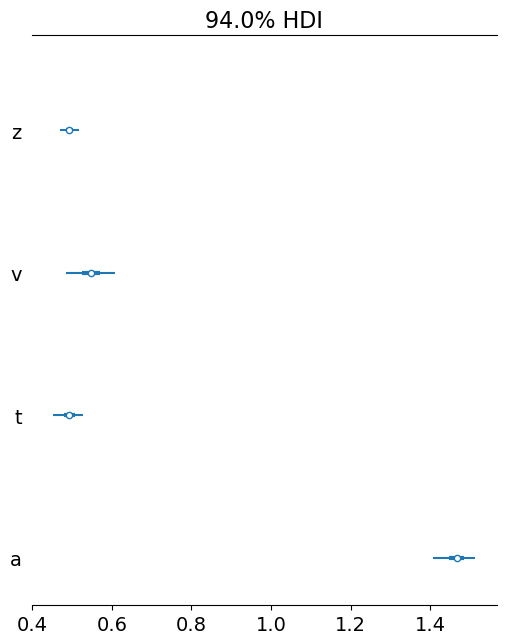

In [33]:
az.plot_forest(simple_ddm.traces, combined=True)

In [35]:
simple_ddm.traces

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

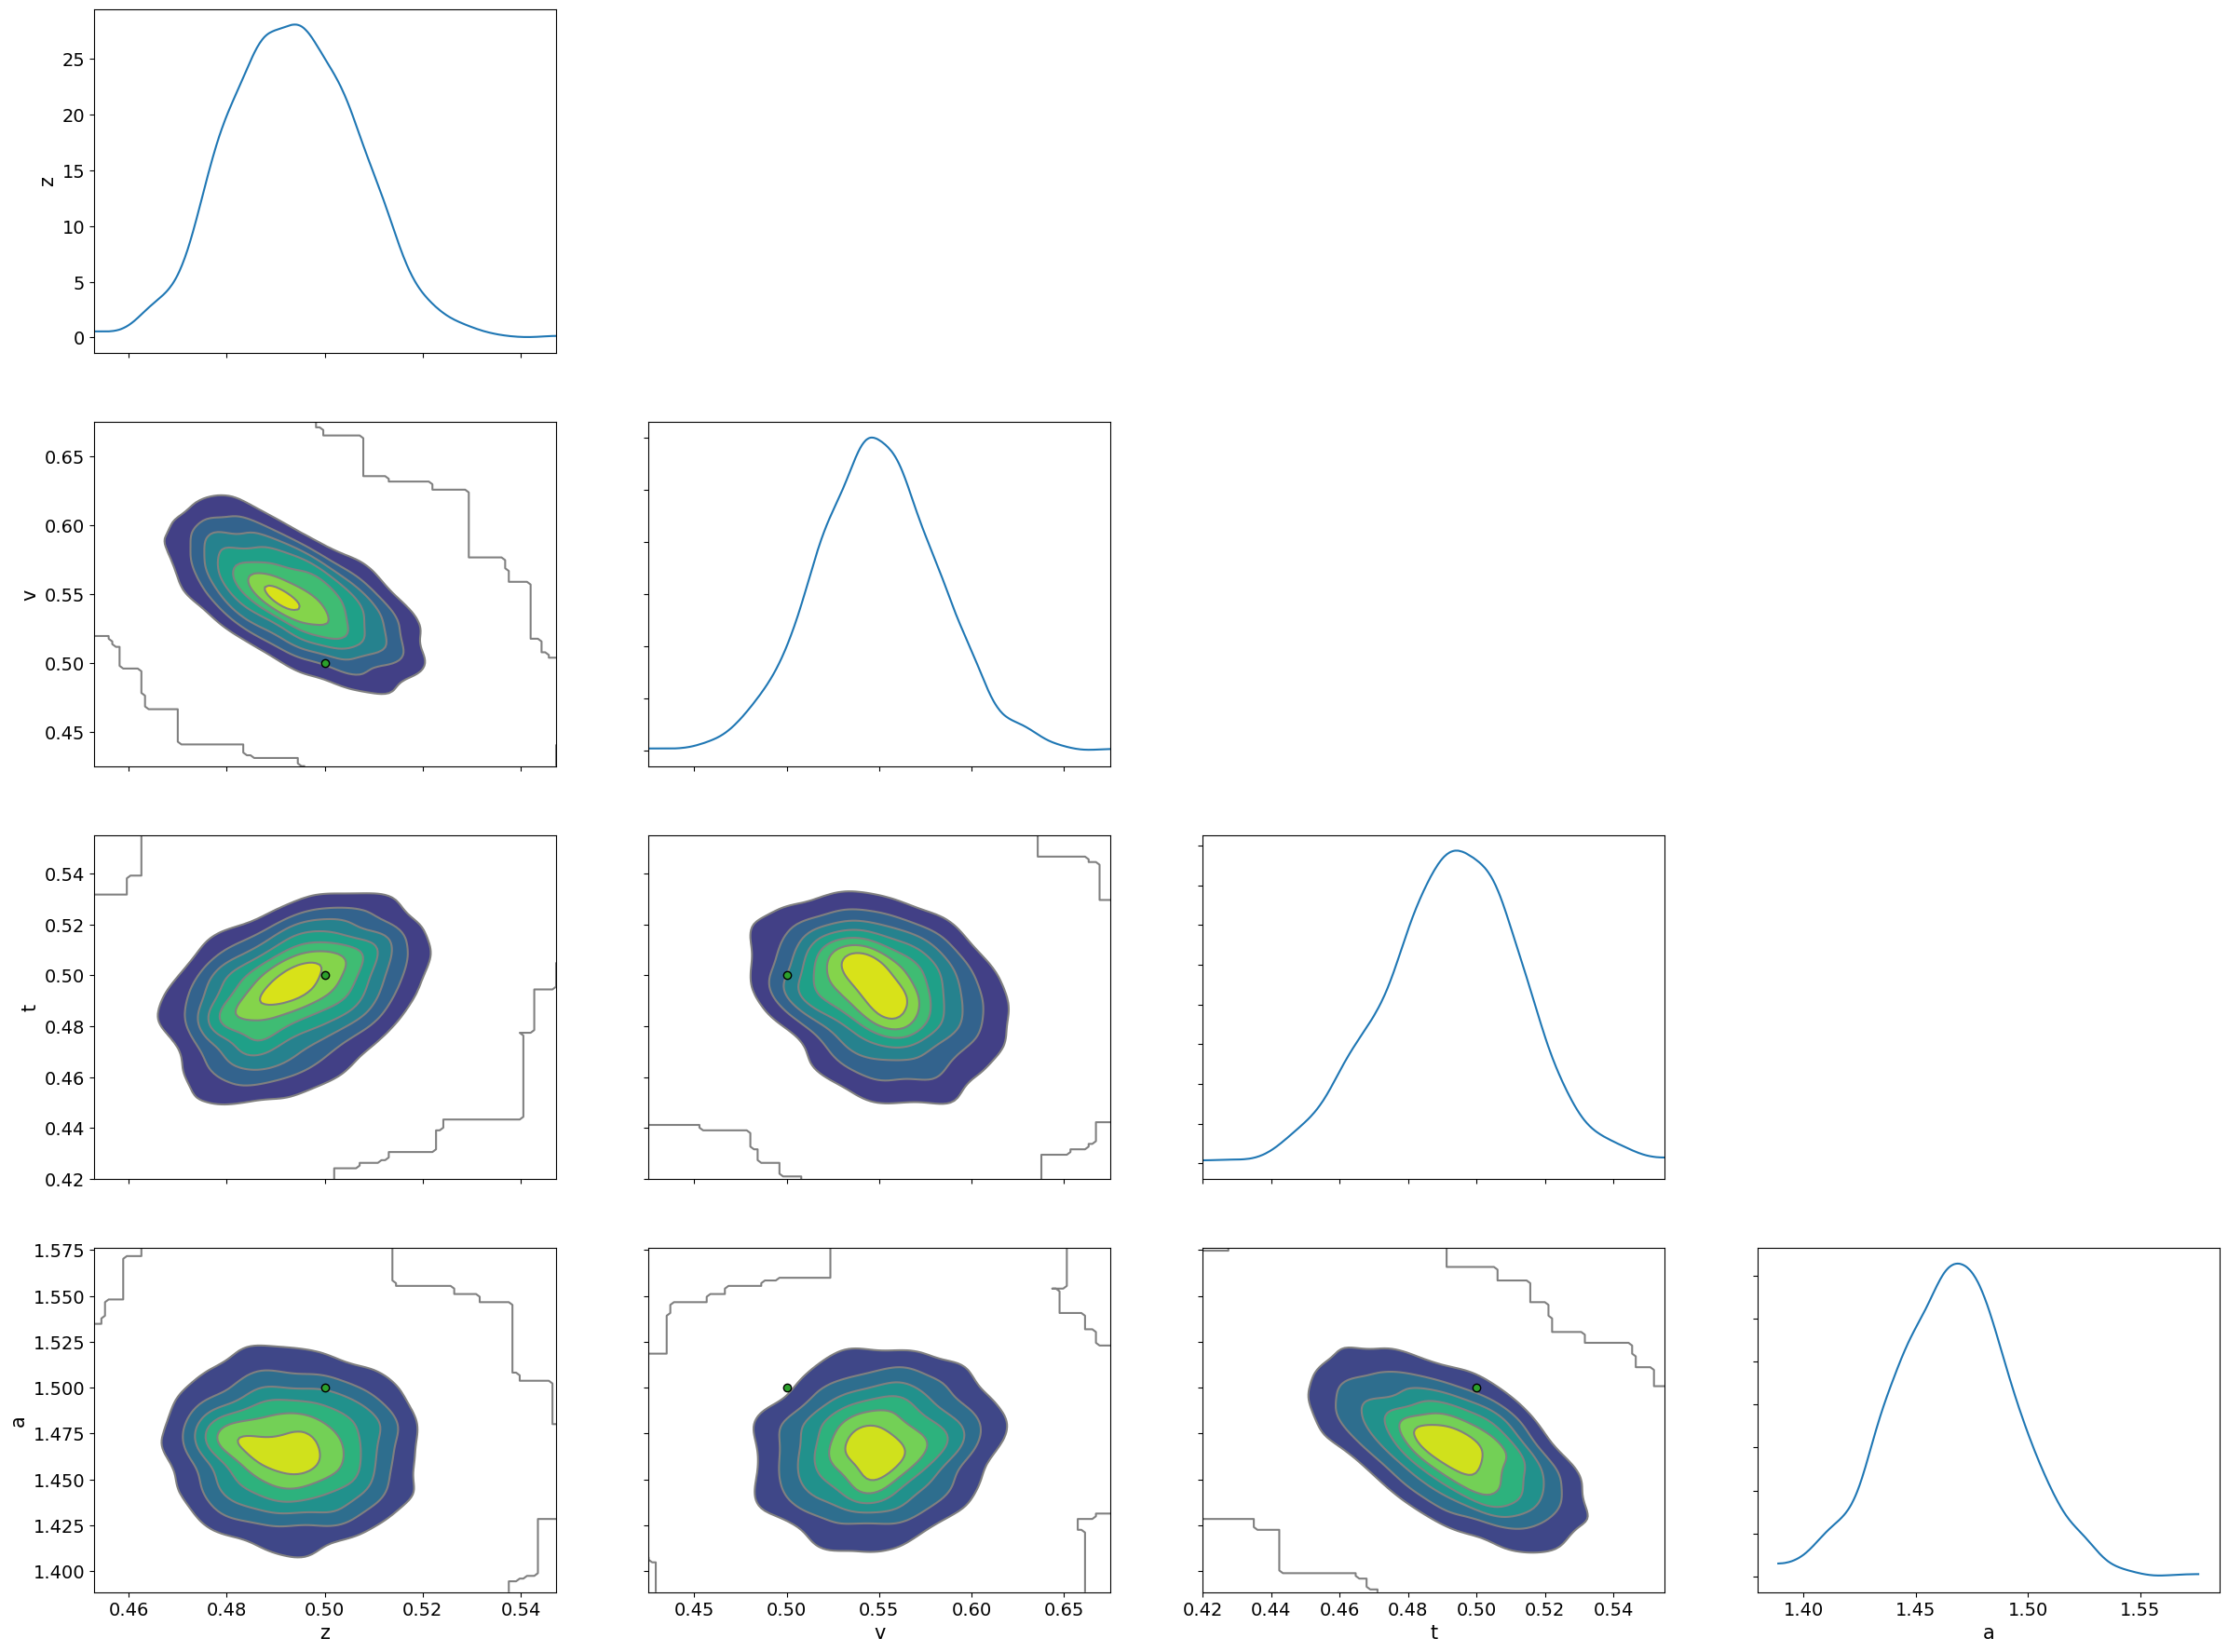

In [38]:
ax = az.plot_pair(
    simple_ddm.traces,
    kind="kde",
    reference_values=true_params,
    marginals=True,
)

## Basic Hierarchical Model

Now that we understand the workflow a bit more, we can start setting up a hierarchical model workflow with HSSM.



In [41]:
def simulate_hddm(
    n_participants: int = 10, 
    n_trials: int = 300,
    threshold: float = 1.5,
    bias: float = 0.5,
    ndt: float = 1.5,
):
    
    for i in range(n_participants):
        

        
        a_i = threshold
        z_i = bias
        t_i = ndt

    pass
        

In [42]:
# Make some hierarchical data (need to make a wrapper and make this more sementic)
n_participants = 15  # number of participants
n_trials = 200  # number of trials per participant

sd_v = 0.5  # sd for v-intercept
mean_v = 0.5  # mean for v-intercept

data_list = []
for i in range(n_participants):
    # Make parameters for participant i
    v_intercept_i = RNG.normal(mean_v, sd_v, size=1)
    x = RNG.uniform(-1, 1, size=n_trials)
    v_x_i = 0.8
    y = RNG.uniform(-1, 1, size=n_trials)
    v_y_i = 0.3
    v_i = v_intercept_i + (v_x_i * x) + (v_y_i * y)

    a_i = 1.5
    t_i = 0.5
    z_i = 0.5

    # true_values = np.column_stack(
    #     [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=n_trials)]
    # )

    data_tmp = hssm.simulate_data(
        model="ddm", theta=dict(v=v_i, a=a_i, z=z_i, t=t_i), size=1
    )
    data_tmp["participant_id"] = i
    data_tmp["x"] = x
    data_tmp["y"] = y

    data_list.append(data_tmp)

In [43]:
# Make single dataframe out of participant-wise datasets
hierarchical_dataset = pd.concat(data_list)
hierarchical_dataset

,rt,response,participant_id,x,y
0,1.073951,-1.0,0,-0.235981,-0.361572
1,3.368991,-1.0,0,0.654296,0.399595
2,1.060951,-1.0,0,0.674511,-0.936779
3,0.943358,1.0,0,0.951618,0.645663
4,1.154215,-1.0,0,-0.845550,0.993392
...,...,...,...,...,...
195,1.991616,1.0,14,0.505816,-0.701499
196,1.140043,1.0,14,-0.709123,0.951621
197,1.560904,-1.0,14,-0.851799,0.039005
198,1.017460,1.0,14,0.831724,0.960890


In [44]:
hierarchical_model = hssm.HSSM(
    data=hierarchical_dataset,
    model="ddm",
    noncentered=True,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 0.5,
                },
                "x": {"name": "Normal", "mu": 0.0, "sigma": 0.5},
                "y": {"name": "Normal", "mu": 0.0, "sigma": 0.5},
            },
            "formula": "v ~ 1 + (1|participant_id) + x + y",
            "link": "identity",
        }
    ],
)

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


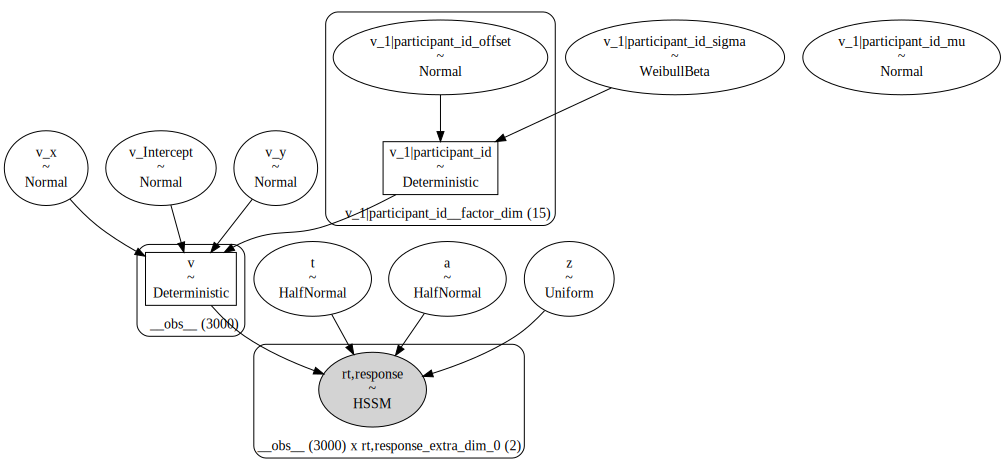

In [34]:
hierarchical_model.graph()

In [ ]:
hierarchical_samples = hierarchical_model.sample(
    sampler="mcmc",
    chains=2,
    cores=1,
    draws=500,
    tune=1000,
    mp_ctx="spawn",
)

Using default initvals. 

The model has already been sampled. Overwriting the previous inference object. Any previous reference to the inference object will still point to the old object.


Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [t, a, z, v_Intercept, v_x, v_y, v_1|participant_id_mu, v_1|participant_id_sigma, v_1|participant_id_offset]


c:\envs\hssm-meta\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2051 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\envs\hssm-meta\lib\site-packages\pymc\pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 1000/1000 [00:03<00:00, 319.31it/s]


### Diagnostics

Sampling takes a while, so later.

In [37]:
az.summary(hierarchical_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_1|participant_id_offset[0],0.786,0.265,0.304,1.278,0.019,0.013,204.0,567.0,1.01
v_1|participant_id_offset[1],-1.475,0.352,-2.086,-0.808,0.022,0.016,251.0,488.0,1.00
v_1|participant_id_offset[2],1.517,0.331,0.944,2.162,0.023,0.016,213.0,363.0,1.01
v_1|participant_id_offset[3],1.377,0.323,0.783,1.927,0.022,0.015,221.0,353.0,1.00
v_1|participant_id_offset[4],1.146,0.301,0.572,1.661,0.020,0.014,236.0,529.0,1.01
v_1|participant_id_offset[5],0.815,0.271,0.350,1.371,0.018,0.013,222.0,429.0,1.01
v_1|participant_id_offset[6],-0.592,0.272,-1.089,-0.071,0.018,0.013,235.0,421.0,1.00
v_1|participant_id_offset[7],-0.614,0.272,-1.121,-0.120,0.018,0.012,242.0,463.0,1.00
v_1|participant_id_offset[8],-0.741,0.285,-1.235,-0.157,0.019,0.013,230.0,399.0,1.00
v_1|participant_id_offset[9],1.017,0.289,0.477,1.553,0.019,0.013,238.0,464.0,1.01


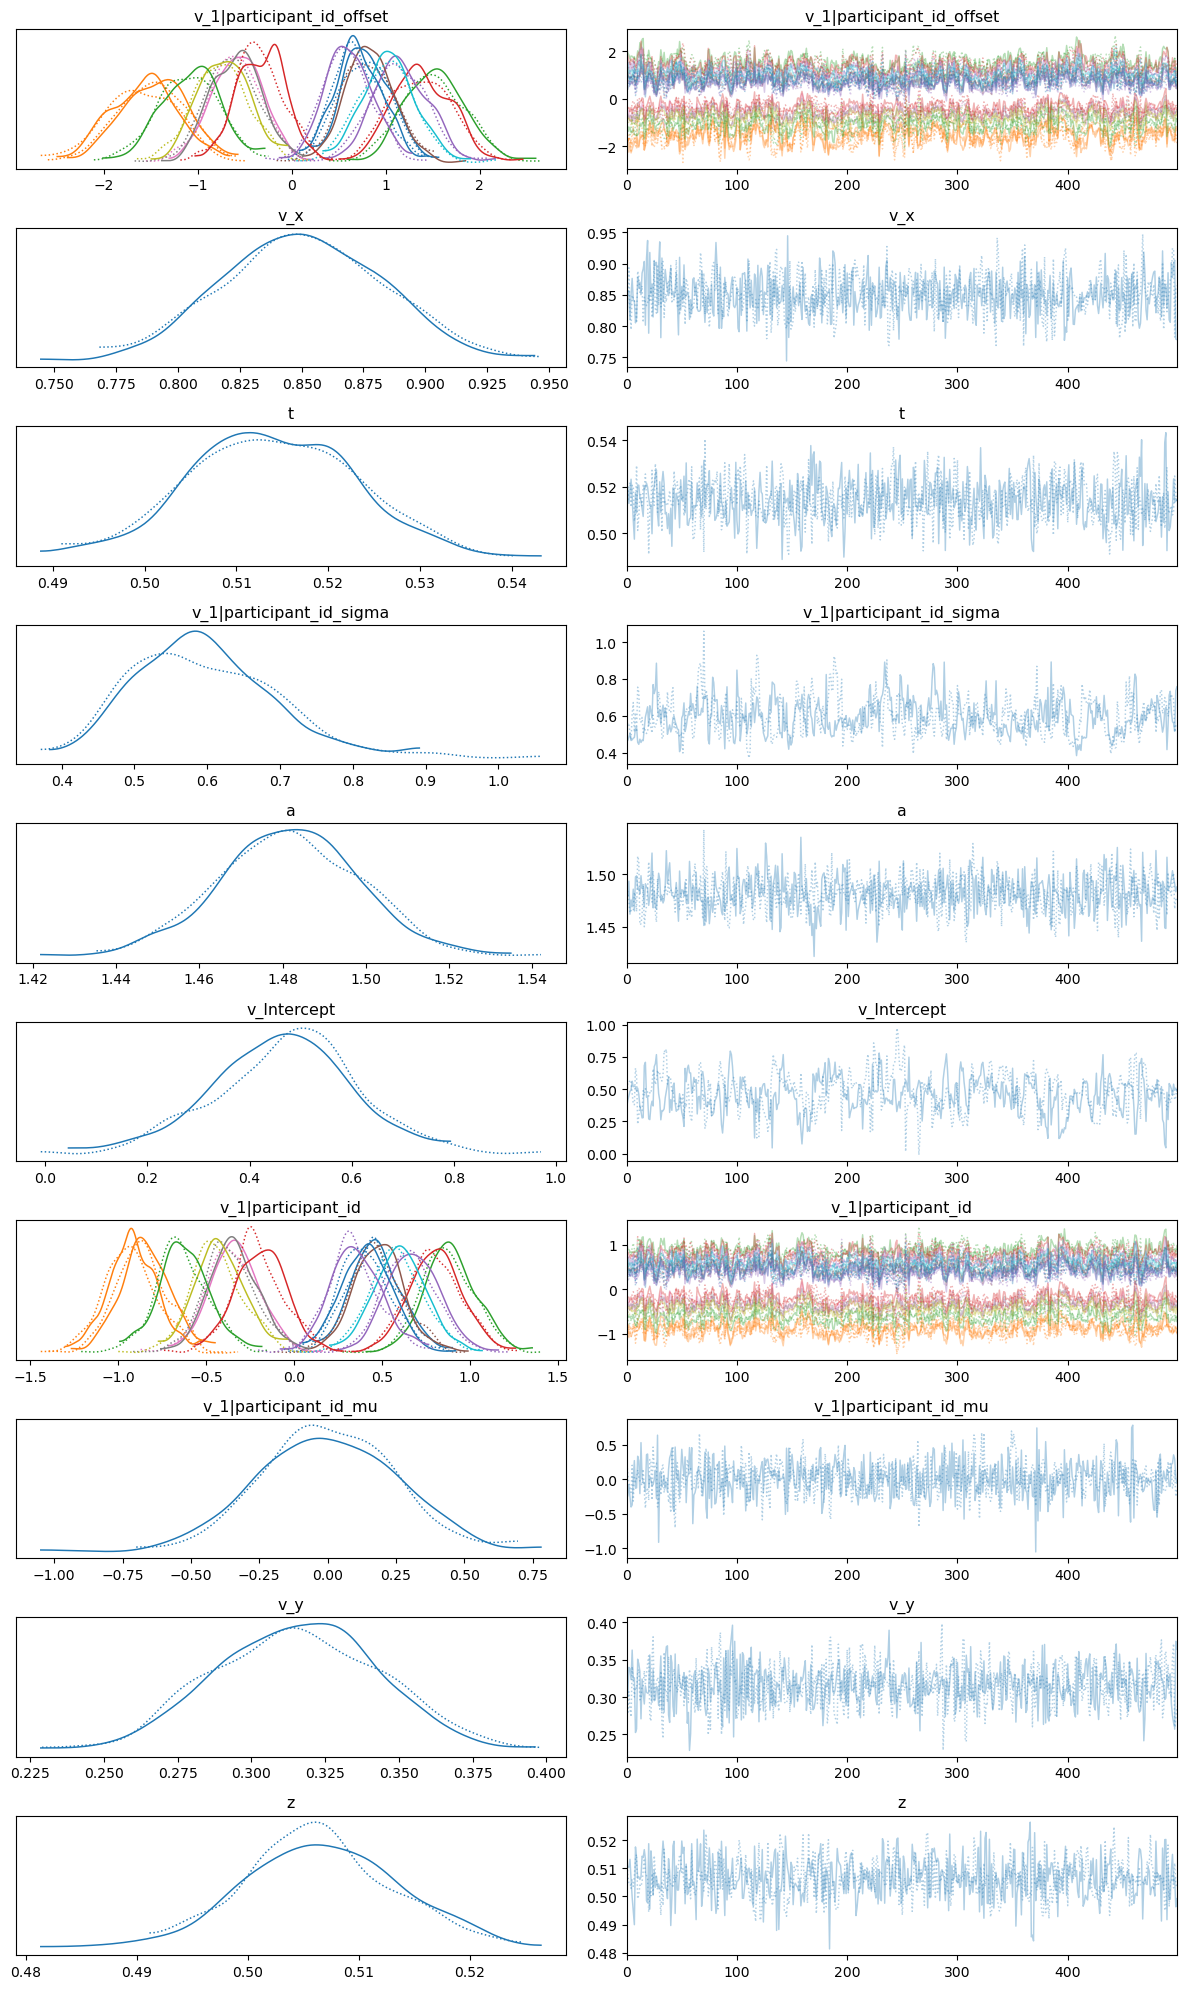

In [39]:
az.plot_trace(hierarchical_samples)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

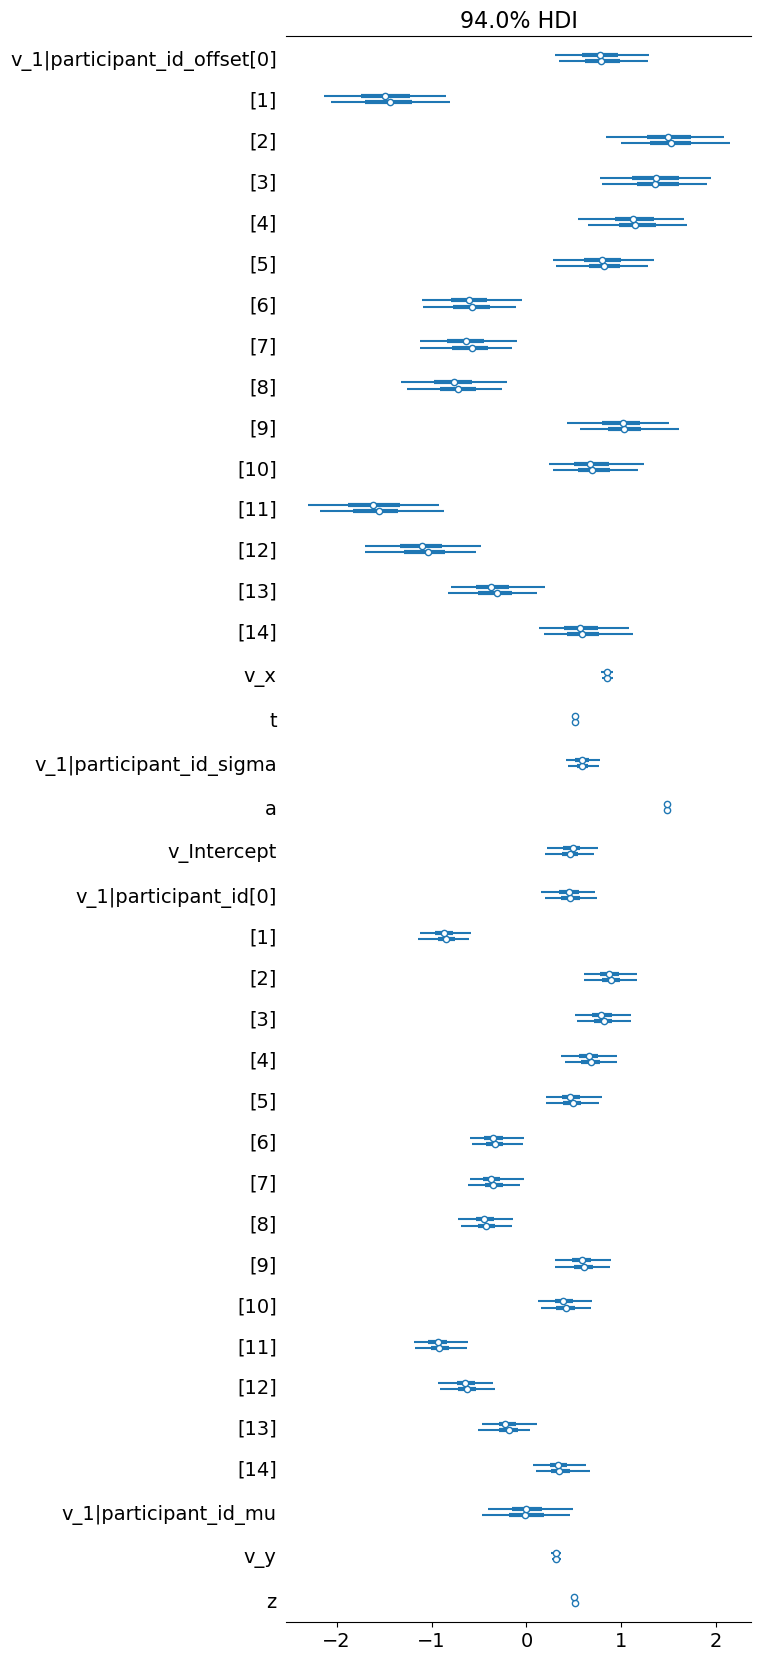

In [40]:
az.plot_forest(hierarchical_samples)

## Exercise: Modeling a DDM Variant with Collapsing Bounds

In some instances of perceptual decision-making (i.e., when an urgancy signal is present), we model the process as a DDM with **collapsing bounds** [(Hawkins et al., 2015)](https://www.jneurosci.org/content/35/6/2476.short). HSSM contains many supported model variants, and the collapsing bounds models are represented by an extra parameter $\theta$, which represents the slope of the bounds that collapse to the center.

In [52]:
# Aside: you can find a list of all supported models in HSSM using the following line of code:
hssm.defaults.SupportedModels

# We would choose the 'angle' model for our collapsing-bounds DDM.

typing.Literal['ddm', 'ddm_sdv', 'full_ddm', 'angle', 'levy', 'ornstein', 'weibull', 'race_no_bias_angle_4', 'ddm_seq2_no_bias', 'lba3', 'lba2']

In [ ]:
collapsing_bounds_params = true_params

# Add an extra angle parameter
### Our code here

In [ ]:
# Simulate data for the collapsing-bounds DDM. 
# You can also make this simulation hierarchical by varying the angles for each participant.
### Our code here

In [ ]:
# Create a model for the collapsing-bounds DDM, and visualize the model graphically
### Our code here

In [ ]:
# Sample from the model
### Our code here

In [51]:
# Inspect the samples via ArViZ either numerically or through visual diagnostics.
### Our code here